In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np

pd.set_option("display.max_rows", 10, "display.max_columns", None)


In [2]:
febMar20 = pd.read_csv('Simmer_FebMar20.csv', low_memory=False)
decJan19 = pd.read_csv('Simmer_DecJan19.csv', low_memory=False)
augSep19 = pd.read_csv('Simmer_AugSep19.csv', low_memory=False)
octNov19 = pd.read_csv('Simmer_OctNov19.csv', low_memory=False)
peopleDF = pd.read_csv('People_Sample.csv', low_memory=False)

In [3]:
nullCountsAugSep = pd.DataFrame({'Column Name': augSep19.columns, 'Null Count' : [augSep19[column].isnull().sum() for column in augSep19.columns]})
nullCountsDecJan = pd.DataFrame({'Column Name': decJan19.columns, 'Null Count' : [decJan19[column].isnull().sum() for column in decJan19.columns]})
nullCountsFebMar = pd.DataFrame({'Column Name': febMar20.columns, 'Null Count' : [febMar20[column].isnull().sum() for column in febMar20.columns]})
nullCountsOctNov = pd.DataFrame({'Column Name': octNov19.columns, 'Null Count': [octNov19[column].isnull().sum() for column in octNov19.columns]})
nullCountsAugSep[nullCountsAugSep['Null Count'] < 0.3 * len(augSep19)]
nullCountsDecJan[nullCountsDecJan['Null Count'] < .3 * len(decJan19)]
nullCountsFebMar[nullCountsFebMar['Null Count'] < .2 * len(febMar20)]
nullCountsOctNov[nullCountsOctNov['Null Count'] < .3 * len(octNov19)]

,Column Name,Null Count
0,name,0
1,distinct_id,0
2,time,0
3,sampling_factor,0
4,dataset,0
...,...,...
27,properties.UUId,2227
28,properties.mp_country_code,1042
29,properties.mp_device_model,2461
30,properties.mp_lib,1050


In [4]:
final_selected_columns = ['name',
 'distinct_id',
 'time',
 'properties.$ae_session_length',
 'properties.$city',
 'properties.$region',
 'properties.mp_country_code',
 'properties.locationSetting',
 'properties.notificationSettings',
 'properties.FirstTimeUploaded',
 'properties.$had_persisted_distinct_id',
 'properties.Signup With',
 'properties.imageAdded',
 'properties.commentAdded',
 'properties.commentLength',
 'properties.ImageUploaded']

In [5]:
columns_values = {}
df_list = [febMar20, decJan19, octNov19, augSep19]
selected_columns = final_selected_columns
for column in selected_columns:
    for df in df_list:
        if column in columns_values:
            columns_values[column] += list(df[column])
        else:
            columns_values[column] = []
            columns_values[column] += list(df[column])

past7Months = pd.DataFrame(columns_values)

In [6]:
past7Months['properties.ImageUploaded']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
190366    NaN
190367    NaN
190368    NaN
190369    NaN
190370    NaN
Name: properties.ImageUploaded, Length: 190371, dtype: object

## 

In [7]:
past7Months['properties.$region'].value_counts()

California              41886
Gujarat                 25055
Illinois                17403
New York                14434
District of Columbia    12427
                        ...  
Muharraq                    1
Lisbon                      1
Västra Götaland             1
St.-Petersburg              1
Haringey                    1
Name: properties.$region, Length: 253, dtype: int64

<BarContainer object of 4 artists>

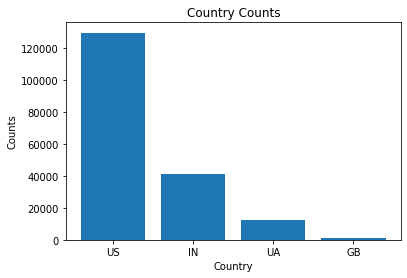

In [8]:
series = past7Months['properties.mp_country_code'].value_counts()
region = series[series > 1000] #More than 1000 records of country_code

plt.title('Country Counts')
plt.xlabel('Country')
plt.ylabel('Counts')
plt.bar(region.index, region.values)

In [9]:
series = past7Months['distinct_id'].value_counts()
series[series > 30]

nb@gmail.com_93                         18347
4E1A70A0-C2DB-46EB-A9C8-B4F0B0815771    12049
richard.z.wu@gmail.com_136               6437
vaibhavverma9@uchicago.edu_56            5482
ab.codebase@gmail.com_52                 3474
                                        ...  
E333EFA7-A654-4093-8A40-A5E5DF5C2F83       31
C5B4EC50-AC41-41C2-B805-B806F0A0425C       31
A71837A0-01C8-48D2-9D54-997EBF3D78D2       31
72FB8B18-57A7-45AD-B332-A0253FE17B14       31
01195431-5FE0-46CB-8EE9-DFF4EBFA54E7       31
Name: distinct_id, Length: 971, dtype: int64

In [10]:
def filter_nan(df, threshold):
    length = len(df)
    result = pd.DataFrame()
    for col in df.columns:
        if (df[col].isnull().sum() < length * threshold):
            result[col] = df[col]
    return result

In [11]:
def clean_people(people_data, features):
    people_data = filter_nan(people_data, 0.5)
    people_data = people_data.loc[:, features]
    people_data.rename(columns=lambda x: re.sub('properties.|\$','',x), inplace=True)
    people_data.rename(columns={'Name' : 'name', 'AuthProvider' : 'auth_provider'}, inplace=True)
    people_data['name'].fillna('Unknown', inplace=True)
    people_data['city'].fillna('Unknown', inplace=True)
    people_data['region'].fillna('Unknown', inplace=True)
    people_data['auth_provider'].fillna('Unknown', inplace=True)
    people_data['ae_first_app_open_date'] = pd.to_datetime(people_data['ae_first_app_open_date'])
    people_data['last_seen'] = pd.to_datetime(people_data['last_seen'])
    #fill in missing first_app_open_date with average of all first_app_open_date
    no_nan = people_data[people_data['ae_first_app_open_date'].isnull() == False]
    avg = np.mean(no_nan['ae_first_app_open_date'])
    people_data.loc[people_data['ae_first_app_open_date'].isnull(), 'ae_first_app_open_date'] = pd.to_datetime(avg)
    #add a column for time between first and last session
    people_data['active_timespan'] = people_data['last_seen'] - people_data['ae_first_app_open_date']
    people_data['average_session_time'] = people_data['ae_total_app_session_length']/people_data['ae_total_app_sessions']
    return people_data

In [12]:
# past7Months[past7Months['distinct_id'] == 'Dzavala@uchicago.edu_118'].sort_values(by='time')
# past7Months[['properties.ImageUploaded']][-past7Months['properties.ImageAdded'].isnull()]['properties.ImageAdded'].value_counts()

In [13]:
selected_people_features = ['distinct_id', 
'properties.$ae_total_app_session_length', 
'properties.Name',
'properties.$region',
'properties.$country_code',
'properties.$city',
'properties.AuthProvider',
'properties.$ae_total_app_sessions',
'properties.$timezone',
'properties.$last_seen',
'properties.$ios_app_version',
'properties.$ios_version',
'properties.$ios_device_model',
'properties.$ios_lib_version',
'properties.$ae_first_app_open_date'
]

In [14]:
people_cleaned = clean_people(peopleDF, selected_people_features)
people_cleaned.drop('region', axis=1, inplace=True)
people_cleaned.drop('city', axis=1, inplace=True)
people_cleaned.to_csv('cleaned_people.csv')

In [15]:
people_events = past7Months.merge(people_cleaned, how='left', on='distinct_id')
people_events

,name_x,distinct_id,time,properties.$ae_session_length,properties.$city,properties.$region,properties.mp_country_code,properties.locationSetting,properties.notificationSettings,properties.FirstTimeUploaded,properties.$had_persisted_distinct_id,properties.Signup With,properties.imageAdded,properties.commentAdded,properties.commentLength,properties.ImageUploaded,ae_total_app_session_length,name_y,country_code,auth_provider,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time
0,$ae_session,fac4dd756360cc15,1582560733000,20.3,San Francisco,California,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,AppOpen,fac4dd756360cc15,1582560712000,NaN,San Francisco,California,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524264000,12.8,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524376000,106.3,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,AppOpen,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524243000,NaN,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787552000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190367,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787554000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190368,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787555000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190369,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787559000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [16]:
def clean_event(event_data, features):
    event_data = event_data.loc[:, features]
    event_data.rename(columns=lambda x: re.sub('properties.|\$','',x), inplace=True)
    #clean ImageUploaded: 1 for one upload, 2 for multiple uploads, -1 for no uploads/not applicable
    event_data['ImageUploaded'].fillna(-1, inplace=True)
    event_data['ImageUploaded'] = event_data['ImageUploaded'].astype('int')
    event_data.loc[(event_data['ImageUploaded'] == 1) & (event_data['FirstTimeUploaded'] == True), 'ImageUploaded'] = 1
    event_data.loc[(event_data['ImageUploaded'] == 1) & (event_data['FirstTimeUploaded'] == False), 'ImageUploaded'] = 2
    #clean imageAdded: 0 for false, 1 for true, -1 for not applicable
    applicable = ['Rating Flow - Rate', 'Rating Flow - Resubmit']
    event_data.loc[event_data['name_x'] == 'Rating Flow - Start', 'imageAdded'] = -1
    event_data.loc[event_data['name_x'].isin(applicable).isnull() == True, 'imageAdded'] = 0
    event_data['imageAdded'].fillna(-1, inplace=True)
    event_data.loc[event_data['imageAdded'] == False, 'imageAdded'] = 0
    event_data.loc[event_data['imageAdded'] == 'false', 'imageAdded'] = 0
    event_data.loc[event_data['imageAdded'] == 'false (Skipped)', 'imageAdded'] = 0
    event_data.loc[event_data['imageAdded'] == True, 'imageAdded'] = 1
    event_data.loc[event_data['imageAdded'] == 'true', 'imageAdded'] = 1
    return event_data

In [17]:
people_events = clean_event(people_events, people_events.columns)

In [18]:
people_events['time'] = people_events['time'].astype(int)


In [19]:
data_test = people_events[['name_x','commentLength']][-people_events['commentLength'].isnull()]

In [20]:
people_events[-people_events['ImageUploaded'].isnull()]

,name_x,distinct_id,time,ae_session_length,city,region,mp_country_code,locationSetting,notificationSettings,FirstTimeUploaded,had_persisted_distinct_id,Signup With,imageAdded,commentAdded,commentLength,ImageUploaded,ae_total_app_session_length,name_y,country_code,auth_provider,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time
0,$ae_session,fac4dd756360cc15,1582560733000,20.3,San Francisco,California,US,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,AppOpen,fac4dd756360cc15,1582560712000,NaN,San Francisco,California,US,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524264000,12.8,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524376000,106.3,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,AppOpen,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524243000,NaN,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787552000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190367,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787554000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190368,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787555000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190369,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787559000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN


## Grace Changes

In [21]:
people_events['time'] = [datetime.fromtimestamp(i / 1000.0).strftime('%Y-%m-%d %H:%M:%S.%f') for i in people_events['time']]

In [22]:
people_events = people_events.sort_values('distinct_id').sort_values('time').reset_index(drop=True)

In [23]:
#user_events[user_events['name_x'] != '$ae_session']
people_events['country'] = people_events['mp_country_code'].apply(lambda x: 'NA' if not isinstance(x, str) else 'US' if x == 'US' else 'INTL')
people_events['US'] = people_events['mp_country_code']
people_events['US'] = people_events['US'].apply(lambda x: 2 if not isinstance(x, str) else 1 if x == 'US' else 0)

In [24]:
people_events

,name_x,distinct_id,time,ae_session_length,city,region,mp_country_code,locationSetting,notificationSettings,FirstTimeUploaded,had_persisted_distinct_id,Signup With,imageAdded,commentAdded,commentLength,ImageUploaded,ae_total_app_session_length,name_y,country_code,auth_provider,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time,country,US
0,Collection Flow - Tap New Collection,nb@gmail.com_93,2019-07-31 19:00:01.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0
1,Collection Flow - Tap Collection,nb@gmail.com_93,2019-07-31 19:00:23.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0
2,Menu Page - Accuracy Popup,nb@gmail.com_93,2019-07-31 19:00:30.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0
3,Profile - Change Section,nb@gmail.com_93,2019-07-31 19:00:39.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0
4,Profile - Change Section,nb@gmail.com_93,2019-07-31 19:00:39.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,AppOpen,7CC49913-7423-4B30-8D3C-34FD2202BF87,2020-03-29 04:28:30.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1
190367,AppOpen,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1
190368,Visit Home Page,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1
190369,$ae_updated,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1


In [25]:
people_events[-people_events['commentAdded'].isnull()]['name_x'].value_counts()

Rating Flow - Complete    2597
Rating Flow - Rate          10
Name: name_x, dtype: int64

## Pranav Changes

In [26]:
cleaned_commentAdded = []
cleaned_commentLength = []

for index, row in people_events.iterrows():
    if row['name_x'] == 'Rating Flow - Complete' or row['name_x'] == 'Rating Flow - Rate':
        if type(row['commentAdded']) == str:
            if 'rue' in row['commentAdded']:
                cleaned_commentAdded += [1]
                cleaned_commentLength += [row['commentLength']]
                
            else:
                cleaned_commentAdded += [0]
                cleaned_commentLength += [0]
                
        else:
            if not row['commentAdded'] or np.isnan(row['commentAdded']):
                cleaned_commentAdded += [0]
                cleaned_commentLength += [0]
            else:
                cleaned_commentAdded += [1]
                cleaned_commentLength += [row['commentLength']]
    else:
        cleaned_commentAdded += [2]
        cleaned_commentLength += [0]
        

In [27]:
people_events['commentAdded'] = cleaned_commentAdded
people_events['commentLength'] = cleaned_commentLength

## Jake Changes

In [28]:
def addsignup(tbl):
    tbl = tbl.copy()
    sign_dict = {}
    sign_array = ['Foodie', 'Facebook', 'Google']
    Fasttbl = tbl[tbl['Signup With'].isin(sign_array)]
    for index in np.arange(len(tbl)):
        if tbl.loc[index, 'Signup With'] in sign_array:
            sign_dict[tbl.loc[index, 'distinct_id']] = tbl.loc[index, 'Signup With']
    new_SignupColumn = []
    for index in np.arange(len(tbl)):
        dis_ID = tbl.loc[index, 'distinct_id']
        if dis_ID in sign_dict.keys():
                #tbl.loc[index, 'Signup With'] = sign_dict.get(dis_ID)
                new_SignupColumn.append(sign_dict.get(dis_ID))
        elif pd.notnull(tbl.loc[index, 'name_x']):
            #tbl.loc[index, 'Signup With'] = 'Foodie'
            new_SignupColumn.append('Foodie')
        elif pd.isnull(tbl.loc[index, 'Signup With']):
            #tbl.loc[index, 'Signup With'] = 'guest'
            new_SignupColumn.append('guest')
    tbl['Signup With'] = new_SignupColumn
    return tbl

In [29]:
# def cleanLocation(tbl):
#     tbl = tbl.copy()
#     sign_dict = {}
#     sign_array = ['Only While Using the App', 'Always Allow']
#     for index in np.arange(len(tbl)):
#         setting = tbl.loc[index, 'locationSetting']
#         if setting in sign_array or (type(setting) != float) and 'D' in setting:
#             if setting in sign_array:
#                 sign_dict[tbl.loc[index, 'distinct_id']] = 1
#             elif 'D' in setting:
#                 sign_dict[tbl.loc[index, 'distinct_id']] = 0
                
#     new_LocationColumn = []
#     for index in np.arange(len(tbl)):
#         if tbl.loc[index, 'distinct_id']:
#             dis_ID = tbl.loc[index, 'distinct_id']
#             if dis_ID in sign_dict.keys():
#                 new_LocationColumn.append(sign_dict.get(dis_ID))
#             else:
#                 #Unknowns are 2
#                 new_LocationColumn.append(2)
#     tbl['locationSetting'] = new_LocationColumn
#     return tbl

In [30]:
# def locationPropforUnknown(tbl):
#     tbl = tbl.copy()
#     locationSettings = tbl['locationSetting'].value_counts()
#     num_Allow = locationSettings[1]
#     num_Deny = locationSettings[0]
#     per_Allow = num_Allow / (num_Allow + num_Deny)
#     num_Unknown = locationSettings[2]
#     K = int(round(per_Allow * num_Unknown))
#     arr = np.array([0] * (num_Unknown - K) + [1] * K)
#     np.random.shuffle(arr)
#     tbl = tbl.sort_values('locationSetting', ascending = False)
#     lowerTbl = np.asarray(tbl['locationSetting'][tbl['locationSetting']!= 2])
#     locationColumn = np.concatenate((arr, lowerTbl))
#     tbl['locationSetting'] = locationColumn
#     return tbl

In [31]:
# def cleanNotification(tbl):
#     tbl = tbl.reset_index(drop=True).copy()
#     sign_dict = {}
#     sign_array = ['Allow']
#     for index in np.arange(len(tbl)):
#         setting = tbl.loc[index, 'notificationSettings']
#         if type(setting) is not float:
#             if setting == 'Allow':
#                 sign_dict[tbl.loc[index, 'distinct_id']] = 1
#             elif 'D' in setting:
#                 sign_dict[tbl.loc[index, 'distinct_id']] = 0
    
#     newNotificationColumn = []
#     for index in np.arange(len(tbl)):
#         dis_ID = tbl.loc[index, 'distinct_id']
#         if dis_ID in sign_dict.keys():
#             newNotificationColumn.append(sign_dict.get(dis_ID))
#         else:
#             #Unknowns are 2
#             newNotificationColumn.append(2)     
    
#     tbl['notificationSettings'] = newNotificationColumn
#     return tbl

In [32]:
# def notificationPropforUnknown(tbl):
#     tbl = tbl.copy()
#     notificationSettings = tbl['notificationSettings'].value_counts()
#     num_Allow = notificationSettings[1]
#     num_Deny = notificationSettings[0]
#     per_Allow = num_Allow / (num_Allow + num_Deny)
#     num_Unknown = notificationSettings[2]
#     K = int(round(per_Allow * num_Unknown))
#     arr = np.array([0] * (num_Unknown - K) + [1] * K)
#     np.random.shuffle(arr)
#     tbl = tbl.sort_values('notificationSettings', ascending = False)
#     lowerTbl = np.asarray(tbl['notificationSettings'][tbl['notificationSettings']!= 2])
#     locationColumn = np.concatenate((arr, lowerTbl))
#     tbl['notificationSettings'] = locationColumn
#     return tbl

In [33]:
# cleanedSign = addsignup(people_events)
# cleaned_location = cleanLocation(cleanedSign) 
# withUnknowns = locationPropforUnknown(cleaned_location)
# cleanALL = cleanNotification(withUnknowns)
# people_events = notificationPropforUnknown(cleanALL)

Code to merge past (> 7 months ago) notification and location data with current user data

In [34]:
def clean_notification_data(df):
    notification_df = pd.read_csv('NotificaitonPermission.csv')
    #Save notification data
    notification_df['properties.notificationSettings'] =  notification_df['properties.notificationSettings'].fillna('-1')
    df['notificationSettings'] = df['notificationSettings'].fillna('-1')
    user_notification_settings = {}
    for index, row in notification_df.iterrows():
        user_notification_settings[row['distinct_id']] = row['properties.notificationSettings']
    for index, row in df.iterrows():
         if row['distinct_id'] in user_notification_settings:
            df.at[index,'notificationSettings'] = user_notification_settings[row['distinct_id']]
    df['notificationSettings'] =  df['notificationSettings'].str.replace('Don’t Allow','0')
    df['notificationSettings'] =  df['notificationSettings'].str.replace('Allow','1')
    df['notificationSettings'] =  df['notificationSettings'].astype(int)
    return df

def clean_location_data(df):
    location_df = pd.read_csv('LocationPermission.csv')
    #Save notification data
    location_df['properties.locationSetting'] =  location_df['properties.locationSetting'].fillna('-1')
    df['locationSetting'] = df['locationSetting'].fillna('-1')
    user_location_settings = {}
    for index, row in location_df.iterrows():
        user_location_settings[row['distinct_id']] = row['properties.locationSetting']
    for index, row in df.iterrows():
         if row['distinct_id'] in user_location_settings:
            df.at[index,'locationSetting'] = user_location_settings[row['distinct_id']]
    df['locationSetting'] =  df['locationSetting'].str.replace('Only While Using the App','1')
    df['locationSetting'] =  df['locationSetting'].str.replace('Don’t Allow','0')
    df['locationSetting'] =  df['locationSetting'].str.replace('Always Allow','2')
    df['locationSetting'] =  df['locationSetting'].astype(int)
    return df

In [35]:
people_events = clean_notification_data(people_events)
people_events = clean_location_data(people_events)
people_events['locationSetting'].value_counts()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (30,32,35,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


 1    91413
-1    89798
 0     7374
 2     1786
Name: locationSetting, dtype: int64

## Anna Changes

In [36]:
def auth_provider(df):
    new_columns = pd.get_dummies(df['auth_provider'])
    df=pd.concat([df, new_columns], axis=1)
    df = df.drop('auth_provider', axis=1)
    return df
people_events = auth_provider(people_events)
#drop columns
people_events = people_events.drop(['country_code', 'had_persisted_distinct_id'], axis=1)
#changing session length to seconds
people_events['ae_total_app_session_length'] = people_events['ae_total_app_session_length']/1000
people_events

,name_x,distinct_id,time,ae_session_length,city,region,mp_country_code,locationSetting,notificationSettings,FirstTimeUploaded,Signup With,imageAdded,commentAdded,commentLength,ImageUploaded,ae_total_app_session_length,name_y,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time,country,US,Facebook,Foodie,Google,Unknown
0,Collection Flow - Tap New Collection,nb@gmail.com_93,2019-07-31 19:00:01.000000,NaN,Ahmedabad,Gujarat,IN,1,1,NaN,NaN,-1,2,0.0,-1,630.598,NB’ House,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0,0,1,0,0
1,Collection Flow - Tap Collection,nb@gmail.com_93,2019-07-31 19:00:23.000000,NaN,Ahmedabad,Gujarat,IN,1,1,NaN,NaN,-1,2,0.0,-1,630.598,NB’ House,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0,0,1,0,0
2,Menu Page - Accuracy Popup,nb@gmail.com_93,2019-07-31 19:00:30.000000,NaN,Ahmedabad,Gujarat,IN,1,1,NaN,NaN,-1,2,0.0,-1,630.598,NB’ House,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0,0,1,0,0
3,Profile - Change Section,nb@gmail.com_93,2019-07-31 19:00:39.000000,NaN,Ahmedabad,Gujarat,IN,1,1,NaN,NaN,-1,2,0.0,-1,630.598,NB’ House,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0,0,1,0,0
4,Profile - Change Section,nb@gmail.com_93,2019-07-31 19:00:39.000000,NaN,Ahmedabad,Gujarat,IN,1,1,NaN,NaN,-1,2,0.0,-1,630.598,NB’ House,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,2019-05-30 01:08:51.984962560+00:00,304 days 19:38:15.015037,180.170857,INTL,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,AppOpen,7CC49913-7423-4B30-8D3C-34FD2202BF87,2020-03-29 04:28:30.000000,NaN,Washington,District of Columbia,US,-1,-1,NaN,NaN,-1,2,0.0,-1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
190367,AppOpen,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,1,-1,NaN,NaN,-1,2,0.0,-1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
190368,Visit Home Page,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,1,-1,NaN,NaN,-1,2,0.0,-1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
190369,$ae_updated,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,1,-1,NaN,NaN,-1,2,0.0,-1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0


In [37]:
people_events.to_csv('Cleaned_Data.csv') #Export to cleaned CSV